In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import os
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None # Disable those setting with copy warnings

In [2]:
def set_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Purples').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Purple'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def bar_annot(ax, annot_format='{:.2f}'):
    """Function to annotate bar plots. ax is the barplot axis object. annot_format is the annotation numeric display format.
    """
    for p in ax.patches:
        annot = annot_format.format(p.get_height())
        ax.annotate(annot, (p.get_x(), p.get_height()), weight='bold')

def convert_time(x)->int:
    """run_time column has xxhyym or xxh or yym format. This method converts that into integer minutes. Default return is 0.
    """
    x = x.replace(' ','') # Remove whitespace for processing
    
    if re.match("^([0-9]+)h([0-9]+)m$", x):
        # xxhyym format
        l = x.split('h')
        h = int(l[0])
        ll = l[1].split('m')
        m = int(ll[0])
        return h*60 + m
    elif re.match("^([0-9]+)h$", x):
        # xxh format
        l = x.split('h')
        h = int(l[0])
        return h * 60
    elif re.match("^([0-9]+)m$", x):
        # yym format
        l = x.split('m')
        m = int(l[0])
        return m
    else:
        # Anything else
        return 0

In [3]:
dataset = pd.read_csv('dataset_imdb_original.csv')
dataset.head()

rank                      name  year  rating               genre  \
0     1  The Shawshank Redemption  1994     9.3               Drama   
1     2             The Godfather  1972     9.2         Crime,Drama   
2     3           The Dark Knight  2008     9.0  Action,Crime,Drama   
3     4     The Godfather Part II  1974     9.0         Crime,Drama   
4     5              12 Angry Men  1957     9.0         Crime,Drama   

  certificate run_time                                            tagline  \
0           R   2h 22m  Fear can hold you prisoner. Hope can set you f...   
1           R   2h 55m                         An offer you can't refuse.   
2       PG-13   2h 32m                                    Why So Serious?   
3           R   3h 22m       All the power on earth can't change destiny.   
4    Approved   1h 36m  Life Is In Their Hands -- Death Is On Their Mi...   

      budget  box_office                                              casts  \
0   25000000    28884504  Tim Robbins,Morgan Freeman,Bob Gunton,William ...   
1    6000000   250341816  Marlon Brando,Al Pacino,James Caan,Diane Keato...   
2  185000000  1006234167  Christian Bale,Heath Ledger,Aaron Eckhart,Mich...   
3   13000000    47961919  Al Pacino,Robert De Niro,Robert Duvall,Diane K...   
4     350000         955  Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...   

              directors                                          writers  
0        Frank Darabont                      Stephen King,Frank Darabont  
1  Francis Ford Coppola                  Mario Puzo,Francis Ford Coppola  
2     Christopher Nolan  Jonathan Nolan,Christopher Nolan,David S. Goyer  
3  Francis Ford Coppola                  Francis Ford Coppola,Mario Puzo  
4          Sidney Lumet                                    Reginald Rose

In [4]:
print("Data Size:",dataset.shape)
print("-"* 30)
print("About Dataset:")
dataset.info()
print("-"* 30)
print("Data Columns:",list(dataset.columns))
print("-"* 30)
print("Number of Examples 'N'=",dataset.shape[0])
print("Number of Dimensions 'D'=",dataset.shape[1]-1)
print("-"* 30)
print("Data Check For Any Duplicates:",dataset.duplicated().any())

Data Size: (250, 13)
------------------------------
About Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB
------------------------------
Data Columns: ['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time', 'tagline', 'budget

In [5]:
dataset.describe()

rank         year      rating
count  250.000000   250.000000  250.000000
mean   125.500000  1986.360000    8.307200
std     72.312977    25.125356    0.229081
min      1.000000  1921.000000    8.000000
25%     63.250000  1966.250000    8.100000
50%    125.500000  1994.000000    8.200000
75%    187.750000  2006.000000    8.400000
max    250.000000  2022.000000    9.300000

In [6]:
notavailabe_values = (dataset == 'Not Available').sum()
print(notavailabe_values)

rank            0
name            0
year            0
rating          0
genre           0
certificate     1
run_time        1
tagline         0
budget         39
box_office     30
casts           0
directors       0
writers         0
dtype: int64


# Tratamento de Dados

In [7]:
dataset['budget'] = dataset['budget'].str.replace('$','')
dataset['budget'] = dataset['budget'].str.replace('Not Available','0')
dataset['budget'] = dataset['budget'].apply(lambda x: float(''.join(filter(str.isdigit, str(x)))))
# Convert the "budget" column to a numeric data type, and replace "Not Available" values with NaN
dataset['budget'] = pd.to_numeric(dataset['budget'], errors='coerce', downcast='float')
dataset['budget'] = dataset['budget'].fillna(dataset['budget'].median())


dataset['box_office'] = dataset['box_office'].str.replace('$','')
dataset['box_office'] = dataset['box_office'].str.replace('Not Available','0')
dataset['box_office'] = dataset['box_office'].apply(lambda x: float(''.join(filter(str.isdigit, str(x)))))
dataset['box_office'] = pd.to_numeric(dataset['box_office'], errors='coerce', downcast='float')
dataset['box_office'] = dataset['box_office'].fillna(dataset['box_office'].median())


dataset['return_rate'] = dataset['box_office'] / dataset['budget'] * 100

In [8]:
def runtime_to_minutes(runtime_str):
    if runtime_str == "Not Available":
        return np.nan
    elif "h " in runtime_str:
        hours, minutes = runtime_str.split("h ")
        return int(hours) * 60 + int(minutes[:-1])
    else:
        return int(runtime_str[:-1])

# Apply the function to the run_time column
dataset['runtime_minutes'] = dataset['run_time'].apply(runtime_to_minutes)

In [9]:
dataset.describe()

rank         year      rating        budget    box_office  \
count  250.000000   250.000000  250.000000  2.500000e+02  2.500000e+02   
mean   125.500000  1986.360000    8.307200  4.425786e+07  2.067740e+08   
std     72.312977    25.125356    0.229081  1.626479e+08  3.653295e+08   
min      1.000000  1921.000000    8.000000  0.000000e+00  0.000000e+00   
25%     63.250000  1966.250000    8.100000  1.222000e+06  5.375080e+05   
50%    125.500000  1994.000000    8.200000  9.750000e+06  4.603973e+07   
75%    187.750000  2006.000000    8.400000  3.300000e+07  2.637577e+08   
max    250.000000  2022.000000    9.300000  2.400000e+09  2.799439e+09   

       return_rate  runtime_minutes  
count   220.000000       249.000000  
mean           inf       126.445783  
std            NaN        34.918079  
min       0.002094         2.000000  
25%     195.337830       106.000000  
50%     482.502869       126.000000  
75%    1108.456787       145.000000  
max            inf       238.000000

Drama                         19
Crime,Drama                   14
Animation,Adventure,Comedy    10
Biography,Drama,History        9
Crime,Drama,Mystery            9
Name: genre, dtype: int64

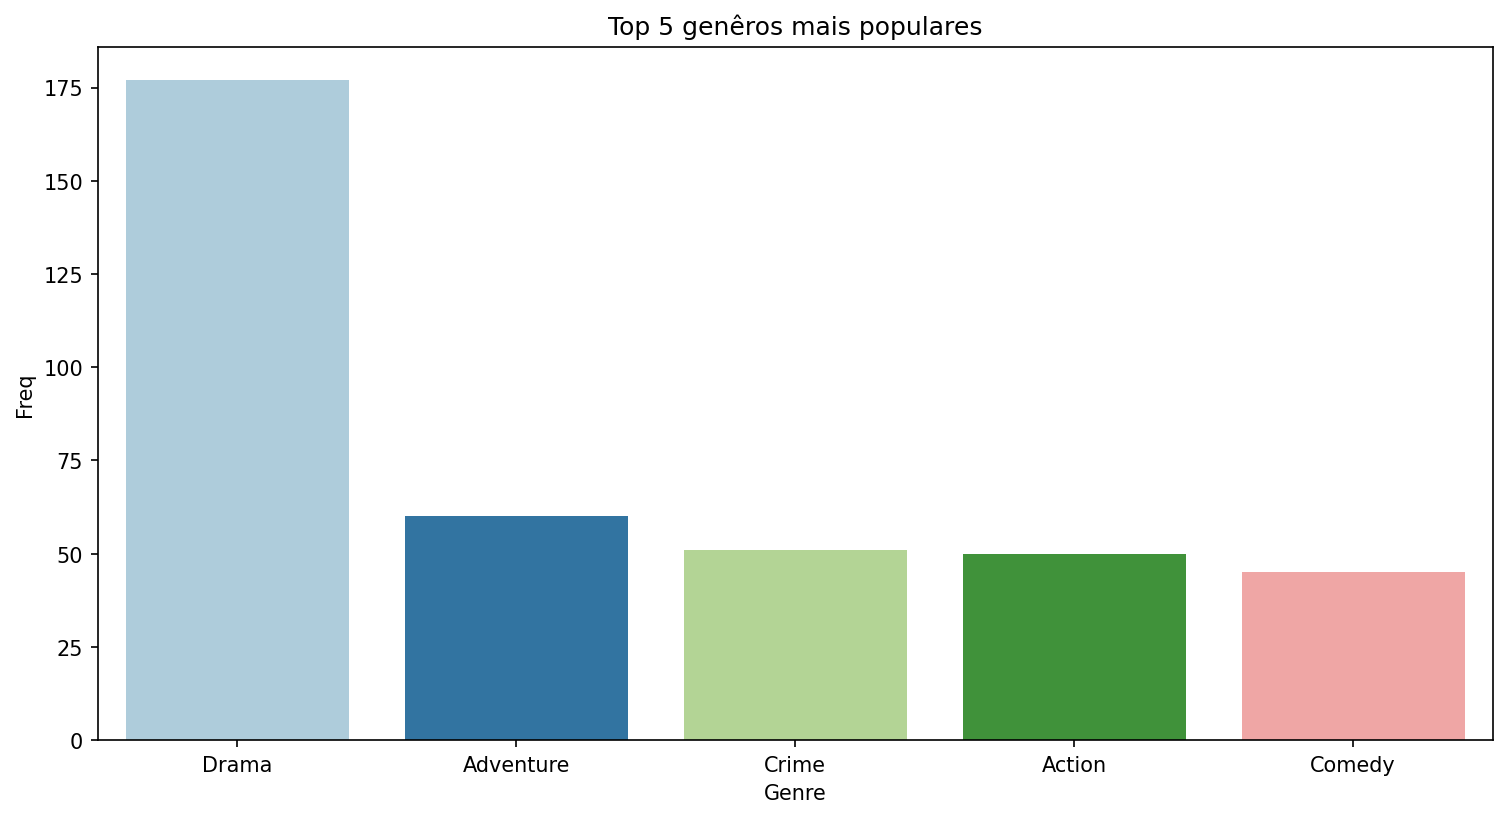

In [10]:
genre_counts = dataset['genre'].value_counts()

display(genre_counts.head(5))

real_gen = ""
for i in dataset['genre']:
    real_gen = real_gen+","+i
all_gen = real_gen.split(',')[1:]
unique_genres = list(set(all_gen))

data = []
for i in unique_genres:
    c = 0
    for j in dataset['genre']:
        if i in j:
            c+=1
    data.append([i, c])
    
gen_df = pd.DataFrame(data, columns=['Genre', 'Freq'])
gen_df.sort_values(by = 'Freq', ascending = False, inplace = True)
gen_df = gen_df.head(5)
plt.figure(figsize=(12,6),dpi = 150)
sns.barplot(data = gen_df, x = 'Genre', y = 'Freq', palette='Paired')
plt.title('Top 5 genêros mais populares')
plt.show()

# O orçamento médio de um filme no conjunto de dados

In [11]:
# Compute the mean budget excluding NaN Values
average_budget = dataset['budget'].mean(skipna=True)

print(f"O orçamento médio para um filme no conjunto de dados é: {average_budget:.2f}")

O orçamento médio para um filme no conjunto de dados é: 44257860.00


# Qual é a receita média de bilheteria de um filme no conjunto de dados?

In [12]:
# Calculate the average box office revenue for movies in the dataset
avg_box_office = dataset['box_office'].mean()

print(f"A receita média de bilheteria para um filme no conjunto de dados é: {avg_box_office:.2f}")

A receita média de bilheteria para um filme no conjunto de dados é: 206773984.00


# Qual é o tempo de execução médio de um filme no conjunto de dados?

In [13]:
# Calculate the average runtime in miunutes
avg_runtime = dataset['runtime_minutes'].mean()

# Convert the average runtime back to hours and minutes format
hours = int(avg_runtime/60)
minutes = int(avg_runtime % 60)
print(f"O tempo de execução médio de um filme no conjunto de dados é: {hours}h {minutes}m.")

O tempo de execução médio de um filme no conjunto de dados é: 2h 6m.


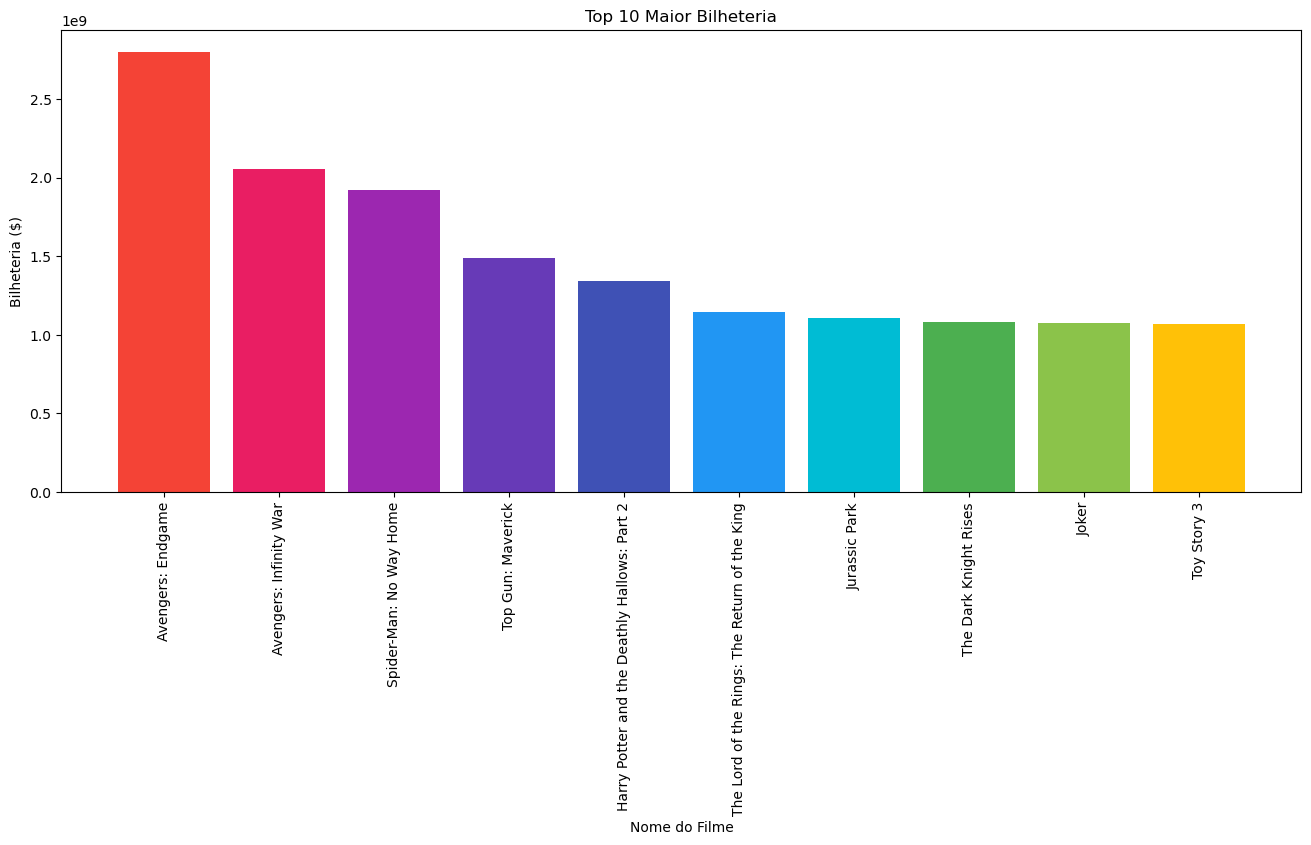

In [14]:
# Filter out the 'Not Available' box office values and sort by descending order
top_grossing = dataset[dataset['box_office'] != 'Not Available'].sort_values(by='box_office', ascending=False).head(10)

# Create a list of 10 different colors
colors = ['#F44336', '#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#2196F3', '#00BCD4', '#4CAF50', '#8BC34A', '#FFC107']

# Plot the bar chart
plt.figure(figsize=(16,6))
plt.bar(x=top_grossing['name'], height=top_grossing['box_office'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Nome do Filme')
plt.ylabel('Bilheteria ($)')
plt.title('Top 10 Maior Bilheteria')
plt.show()

# Quais diretores têm mais filmes no conjunto de dados?

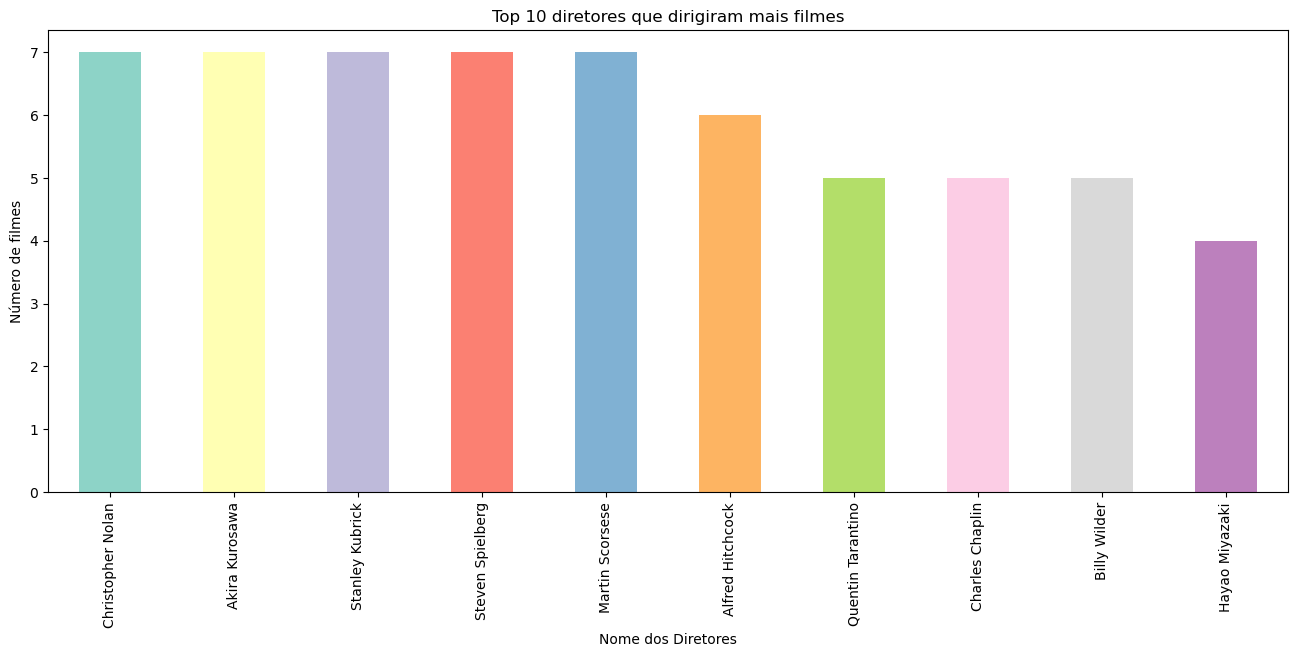

In [15]:
plt.figure(figsize=(16,6))
dataset.groupby('directors').size().sort_values(ascending=False).head(10).plot(kind = 'bar', color = sns.color_palette('Set3'))
plt.xlabel("Nome dos Diretores")
plt.ylabel("Número de filmes")
plt.title("Top 10 diretores que dirigiram mais filmes")
plt.show()

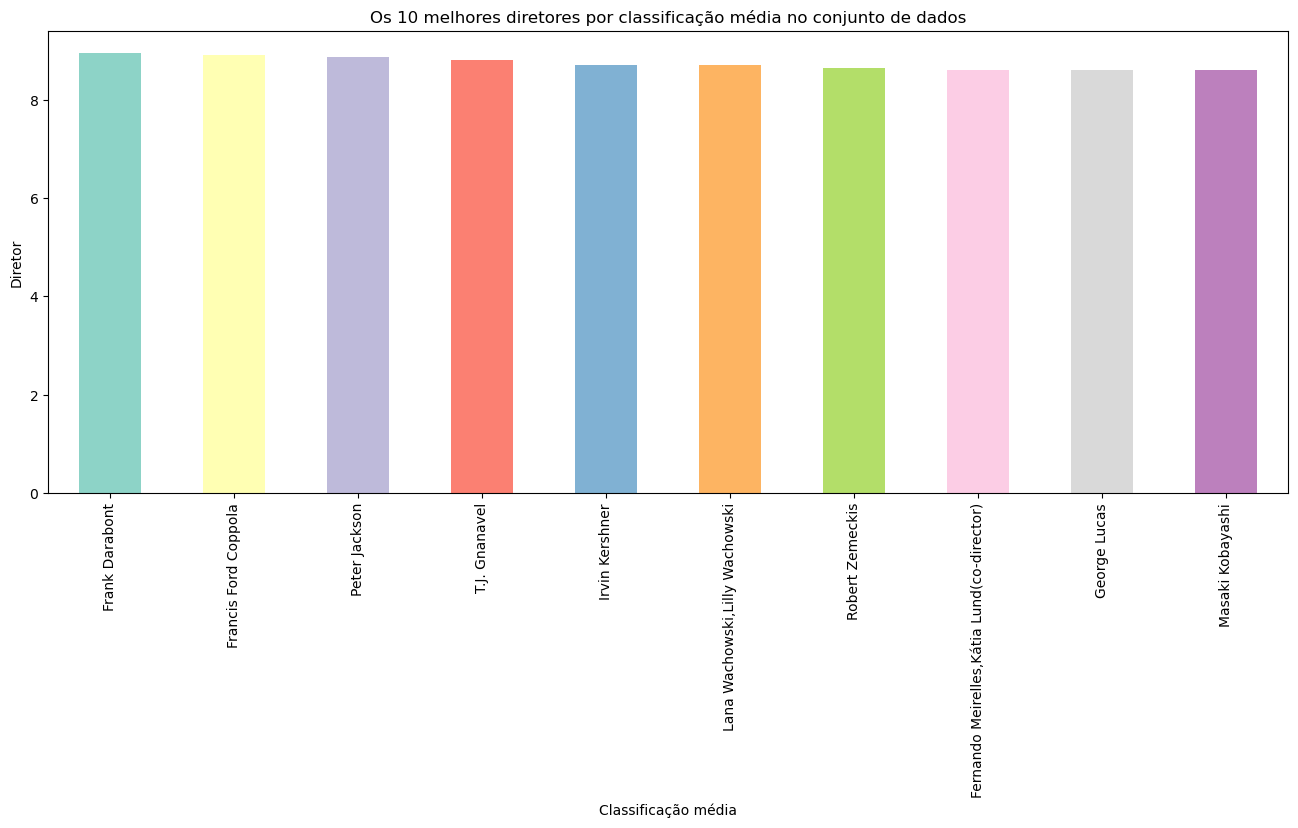

In [16]:
director_ratings = dataset.groupby("directors")["rating"].mean()
director_ratings = director_ratings.sort_values(ascending=False)

top_directors = director_ratings.head(10)

plt.figure(figsize=(16,6))
director_ratings.head(10).plot(kind = 'bar', color = sns.color_palette('Set3'))
plt.xlabel("Classificação média")
plt.ylabel("Diretor")
plt.title("Os 10 melhores diretores por classificação média no conjunto de dados")
plt.show()

In [17]:
na_counts = dataset.apply(lambda x: x.value_counts().get('Not Available', 0))
print('Not Available Values:')
print(na_counts)

Not Available Values:
rank               0
name               0
year               0
rating             0
genre              0
certificate        1
run_time           1
tagline            0
budget             0
box_office         0
casts              0
directors          0
writers            0
return_rate        0
runtime_minutes    0
dtype: int64


# Intervalo de valores que temos no dataset

In [18]:
numerical_data = dataset.select_dtypes(include='number')

for column in numerical_data:
    print("'" + column + "'", "Range Of Values:",numerical_data[column].min(),"-",numerical_data[column].max())
    print("-"* 30)

'rank' Range Of Values: 1 - 250
------------------------------
'year' Range Of Values: 1921 - 2022
------------------------------
'rating' Range Of Values: 8.0 - 9.3
------------------------------
'budget' Range Of Values: 0.0 - 2400000000.0
------------------------------
'box_office' Range Of Values: 0.0 - 2799439104.0
------------------------------
'return_rate' Range Of Values: 0.002093750052154064 - inf
------------------------------
'runtime_minutes' Range Of Values: 2.0 - 238.0
------------------------------


<AxesSubplot:>

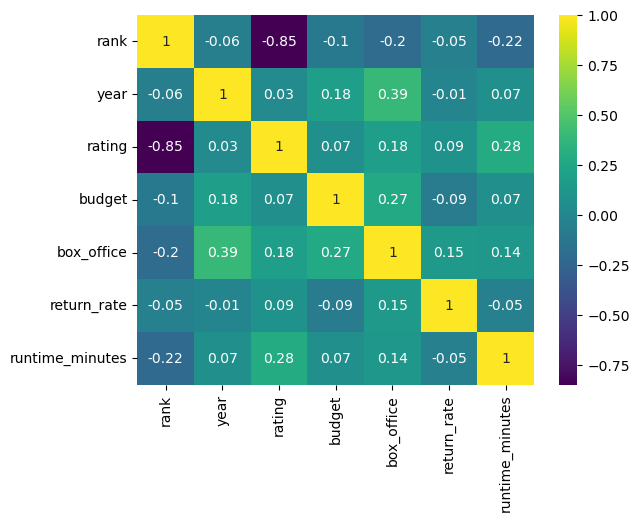

In [19]:
corr = round(dataset.corr(), 2)
sns.heatmap(corr, annot= True, cmap='viridis')

In [20]:
z_scores = numerical_data[numerical_data.columns[1:]].apply(lambda x: (x - x.mean()) / x.std())
outliers = (z_scores > 3) | (z_scores < -3)
print(outliers.sum())

year               0
rating             7
budget             2
box_office         5
return_rate        0
runtime_minutes    6
dtype: int64


# Podemos encontrar o filme com a classificação mais alta em cada gênero

In [21]:
top_movies_by_genre = dataset.groupby("genre").apply(lambda x: x.loc[x["rating"].idxmax()])
top_movies_by_genre[["rating", "name"]].head()

rating  \
genre                              
Action,Adventure             8.4   
Action,Adventure,Comedy      8.1   
Action,Adventure,Drama       9.0   
Action,Adventure,Fantasy     8.7   
Action,Adventure,Mystery     8.3   

                                                                    name  
genre                                                                     
Action,Adventure           Indiana Jones and the Raiders of the Lost Ark  
Action,Adventure,Comedy                                      The General  
Action,Adventure,Drama     The Lord of the Rings: The Return of the King  
Action,Adventure,Fantasy  Star Wars: Episode V - The Empire Strikes Back  
Action,Adventure,Mystery                              North by Northwest

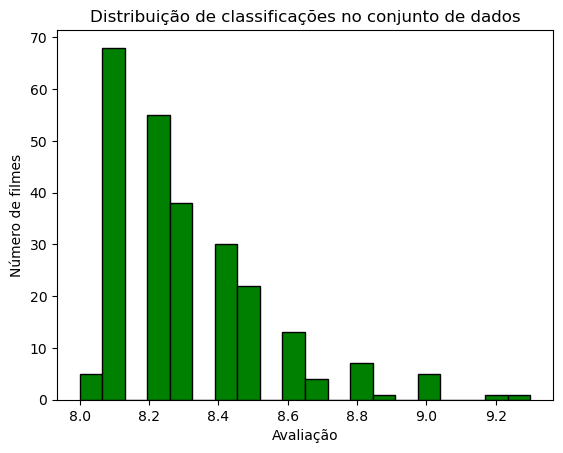

In [22]:
plt.hist(dataset["rating"], bins=20, edgecolor='black', color='green')
plt.xlabel("Avaliação")
plt.ylabel("Número de filmes")
plt.title("Distribuição de classificações no conjunto de dados")
plt.show()

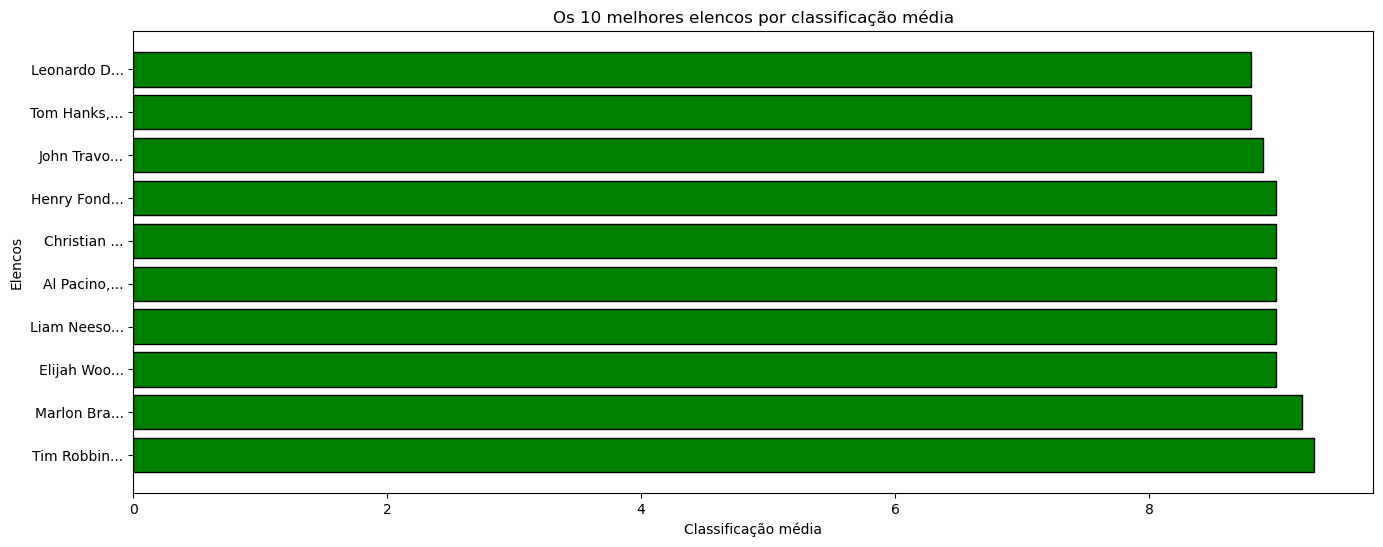

In [23]:
casts_ratings = dataset.groupby("casts")["rating"].mean()
casts_ratings = casts_ratings.sort_values(ascending=False)
top_casts = casts_ratings.head(10)
shortened_labels = [name[:10] + '...' if len(name) > 10 else name for name in top_casts.index]
plt.figure(figsize=(16,6))
plt.barh(top_casts.index, top_casts.values, edgecolor='black', color='green')
plt.yticks(top_casts.index, shortened_labels)
plt.xlabel("Classificação média")
plt.ylabel("Elencos")
plt.title("Os 10 melhores elencos por classificação média")
plt.show()

In [24]:
dict_genres = {}
for genres in dataset.genre:
    genre_list = genres.split(',')
    for g in genre_list:
        genre = g.strip()
        if genre not in dict_genres:
            dict_genres[genre] = 1
        else:
            dict_genres[genre] += 1

print(dict_genres)

{'Drama': 177, 'Crime': 51, 'Action': 50, 'Biography': 29, 'History': 10, 'Adventure': 60, 'Western': 7, 'Romance': 23, 'Sci-Fi': 20, 'Fantasy': 14, 'Mystery': 31, 'Family': 13, 'Thriller': 30, 'War': 23, 'Comedy': 45, 'Animation': 23, 'Music': 4, 'Horror': 5, 'Film-Noir': 4, 'Musical': 1, 'Sport': 5}


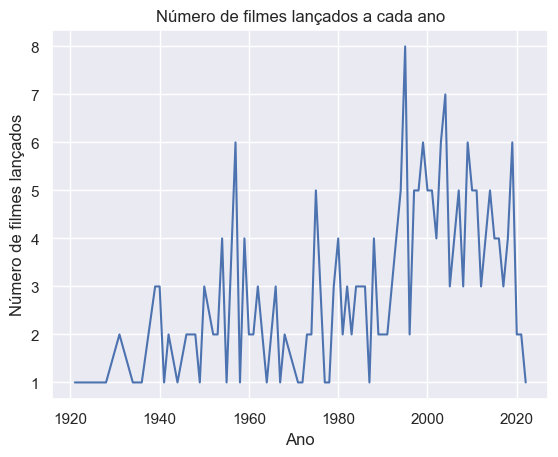

In [25]:
year_counts = dataset['year'].value_counts()

year_counts = dataset.groupby('year')['name'].count()

sns.set(style="darkgrid")
plt.plot(year_counts.index, year_counts.values)
plt.xlabel('Ano')
plt.ylabel('Número de filmes lançados')
plt.title('Número de filmes lançados a cada ano')
plt.show()

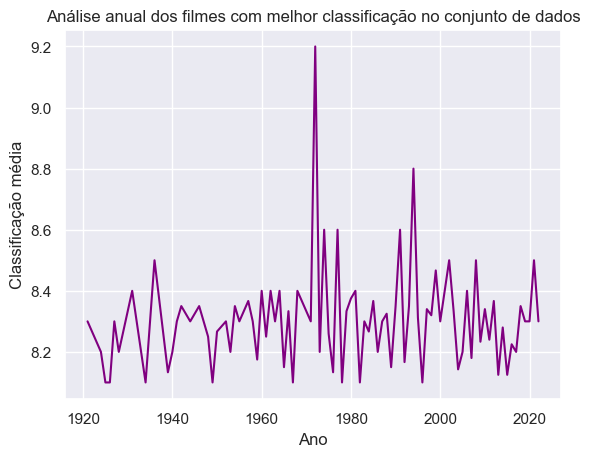

In [26]:
year_ratings = dataset.groupby("year")["rating"].mean()
plt.plot(year_ratings.index, year_ratings.values, color='purple')
plt.xlabel("Ano")
plt.ylabel("Classificação média")
plt.title("Análise anual dos filmes com melhor classificação no conjunto de dados")
plt.show()

In [27]:
scaler = MinMaxScaler()
scaler.fit(dataset[['budget', 'box_office']])
scaled_data = scaler.transform(dataset[['budget', 'box_office']])

genres = dataset['genre'].tolist()
certificates = dataset['certificate'].tolist()
taglines = dataset['tagline'].tolist()

tfidf_genres = TfidfVectorizer()
tfidf_certificate = TfidfVectorizer()
tfidf_tagline = TfidfVectorizer()

tfidf_genres.fit(genres)
tfidf_certificate.fit(certificates)
tfidf_tagline.fit(taglines)

feature_names_genres = tfidf_genres.get_feature_names_out()
feature_names_certificates = tfidf_certificate.get_feature_names_out()
feature_names_taglines = tfidf_tagline.get_feature_names_out()

def Text_Score(text, tfidf, feature_names):
    tfidf_matrix= tfidf.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    text_dict = dict(tfidf_scores)
    text_scores = text_dict.values()
    return sum(text_scores)
dataset['genre_score'] = dataset['genre'].apply(lambda x: Text_Score(x, tfidf_genres, feature_names_genres))
dataset['certificate_score'] = dataset['certificate'].apply(lambda x: Text_Score(x, tfidf_certificate, feature_names_certificates))
dataset['tagline_score'] = dataset['tagline'].apply(lambda x: Text_Score(x, tfidf_tagline, feature_names_taglines))

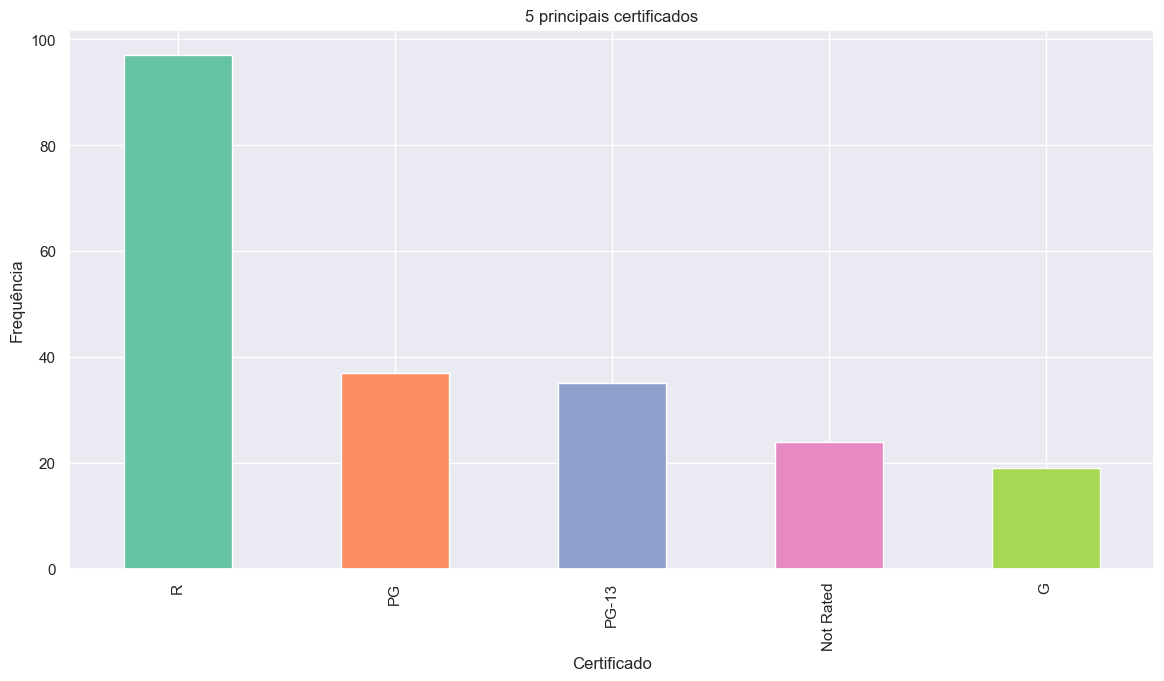

In [28]:
plt.figure(figsize=(14,7))
dataset.groupby('certificate').size().sort_values(ascending=False).head(5).plot(kind = 'bar', color = sns.color_palette('Set2'))
plt.xlabel('Certificado')
plt.ylabel('Frequência')
plt.title("5 principais certificados")
plt.show()

# Porcentagem de filmes com base no ano

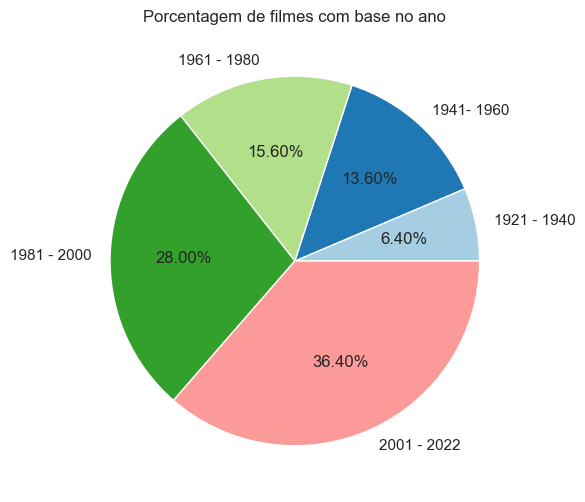

In [29]:
dataset['year'].sort_values()

_21to40 = 0
_41to60 = 0
_61to80 = 0
_81to00 = 0
_01to22 = 0

for i in dataset['year']:
    if i>1920 and i<=1940:
        _21to40+=1
    elif i>1940 and i<=1960:
        _41to60+=1
    elif i>1960 and i<=1980:
        _61to80+=1
    elif i>1980 and i<=2000:
        _81to00+=1
    else: 
        _01to22+=1
        
data = [_21to40, _41to60, _61to80, _81to00, _01to22]
label = ['1921 - 1940', '1941- 1960', '1961 - 1980', '1981 - 2000', '2001 - 2022']
plt.figure(figsize=(12,6))
plt.pie(data,labels=label,colors=sns.color_palette('Paired'),autopct='%.2f%%')
plt.title("Porcentagem de filmes com base no ano")
plt.show()

# Bilheteria por Gênero

In [30]:
fig = px.box(dataset, x='genre', y='box_office', color='genre', title='Bilheteria por Gênero')
fig.show()

# Bilheteira por Certificado

In [31]:
fig = px.violin(dataset, x='certificate', y='box_office', color='genre', title='Bilheteira por Certificado')
fig.show()

In [32]:
dataset.shape

(250, 18)

# Agrupar anos em décadas

In [33]:
dataset['decade']=(10 * (dataset['year'] // 10)).astype(str) + 's'

In [34]:
dataset['time'] = dataset['run_time'].apply(convert_time)
dataset[dataset['time'] < 1]

rank      name  year  rating      genre    certificate       run_time  \
76    77  The Boat  1981     8.4  Drama,War  Not Available  Not Available   

                                              tagline      budget  box_office  \
76  This is the story of 42 raw recruits caught up...  32000000.0  11487676.0   

                                                casts          directors  \
76  Jürgen Prochnow,Herbert Grönemeyer,Klaus Wenne...  Wolfgang Petersen   

                                 writers  return_rate  runtime_minutes  \
76  Wolfgang Petersen,Lothar G. Buchheim    35.898987              NaN   

    genre_score  certificate_score  tagline_score decade  time  
76     1.300542           1.361173       4.858166  1980s     0

In [35]:
dataset.loc[dataset.name == 'The Boat', 'time'] = 149

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               250 non-null    int64  
 1   name               250 non-null    object 
 2   year               250 non-null    int64  
 3   rating             250 non-null    float64
 4   genre              250 non-null    object 
 5   certificate        250 non-null    object 
 6   run_time           250 non-null    object 
 7   tagline            250 non-null    object 
 8   budget             250 non-null    float32
 9   box_office         250 non-null    float32
 10  casts              250 non-null    object 
 11  directors          250 non-null    object 
 12  writers            250 non-null    object 
 13  return_rate        220 non-null    float32
 14  runtime_minutes    249 non-null    float64
 15  genre_score        250 non-null    float64
 16  certificate_score  250 non

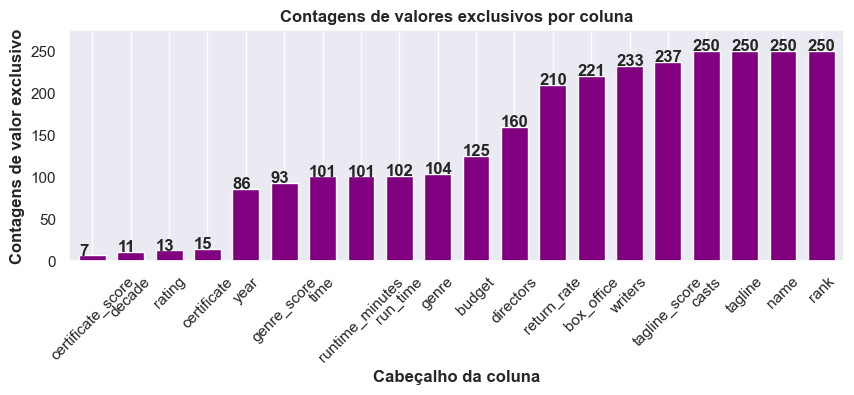

In [37]:
df_unique = dataset.nunique()
ax = df_unique.sort_values().plot(kind='bar', width=0.7, sort_columns=True, ylim=(0, 1.1* df_unique.max()), color='purple')
ax.figure.set_size_inches(10,3)
ax.set_title("Contagens de valores exclusivos por coluna", weight='bold')
ax.yaxis.grid()
plt.ylabel('Contagens de valor exclusivo', weight='bold')
plt.xlabel('Cabeçalho da coluna', weight='bold')
plt.xticks(rotation=45)
bar_annot(ax, '{:d}')

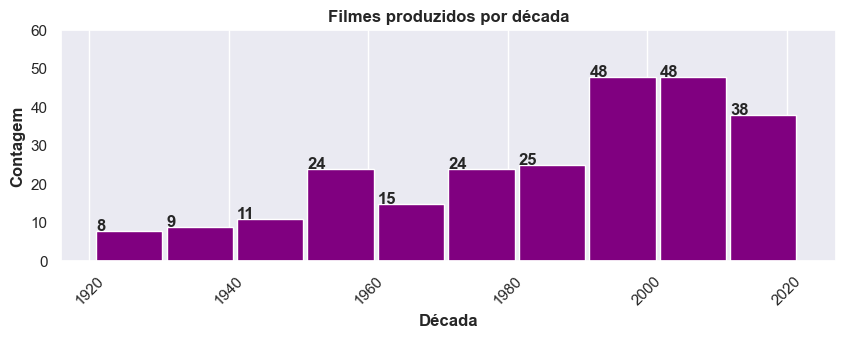

In [38]:
ax = dataset['year'].plot(kind='hist', color='purple', width=9.5, ylim=(0,60))
ax.figure.set_size_inches(10,3)
ax.set_title("Filmes produzidos por década", weight='bold')
ax.yaxis.grid()
plt.ylabel('Contagem', weight='bold')
plt.xlabel('Década', weight='bold')
plt.xticks(rotation=45)
bar_annot(ax,'{:.0f}')
plt.show()

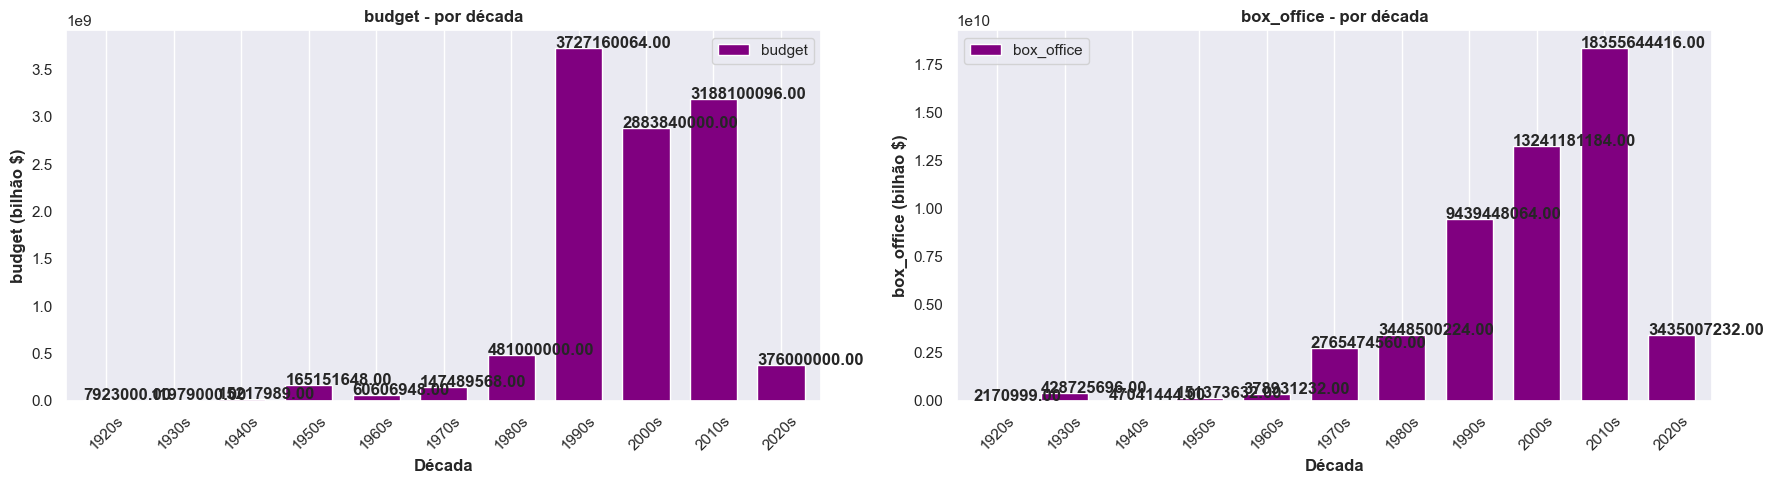

In [39]:
df_cash = dataset[['decade', 'budget', 'box_office']].groupby(['decade']).sum().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18,5))

for i, cc in enumerate(['budget', 'box_office']):    
    ax = df_cash.plot.bar(x='decade', y=cc, color='purple', width=0.7, ax=axs[i], rot=45)
    ax.set_title(cc + " - por década", weight='bold')
    ax.yaxis.grid()
    ax.set_ylabel(cc + ' (bilhão $)', weight='bold')
    ax.set_xlabel('Década', weight='bold')
    bar_annot(ax)
fig.tight_layout()
plt.show()

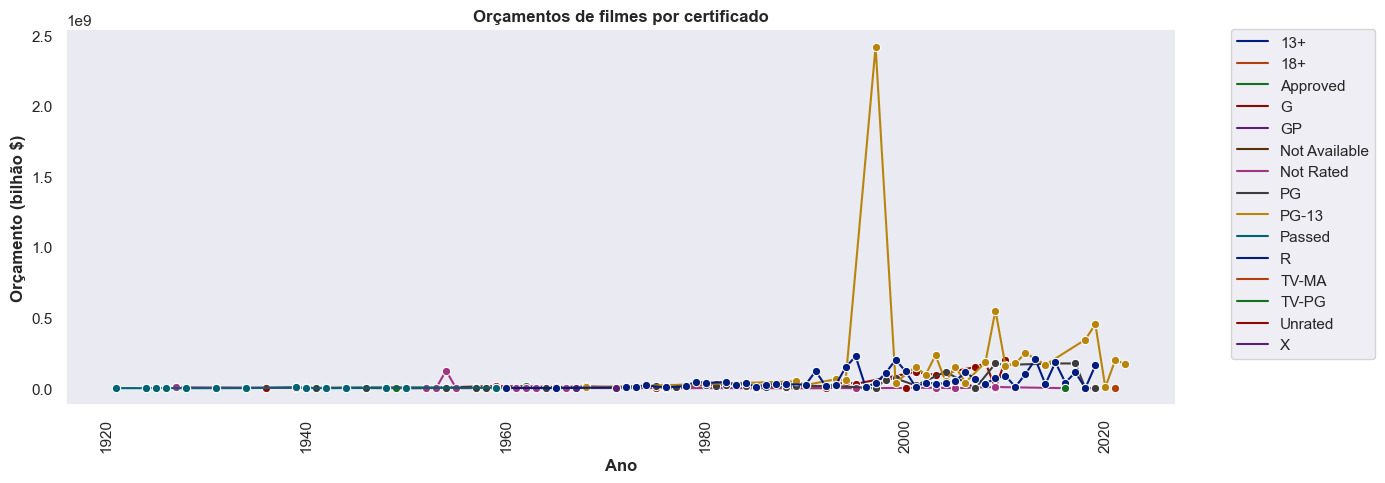

In [40]:
df_agg = dataset[['certificate','budget','year']].groupby(by=['certificate','year']).sum().reset_index()

plt.figure(figsize=(14,5))

ax = sns.lineplot(data=df_agg, x='year',y='budget', hue='certificate', marker='o', palette=sns.color_palette('dark', n_colors=15))
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('Orçamento (bilhão $)', weight='bold')
ax.set_xlabel('Ano', weight='bold')
ax.set_title('Orçamentos de filmes por certificado', weight='bold')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

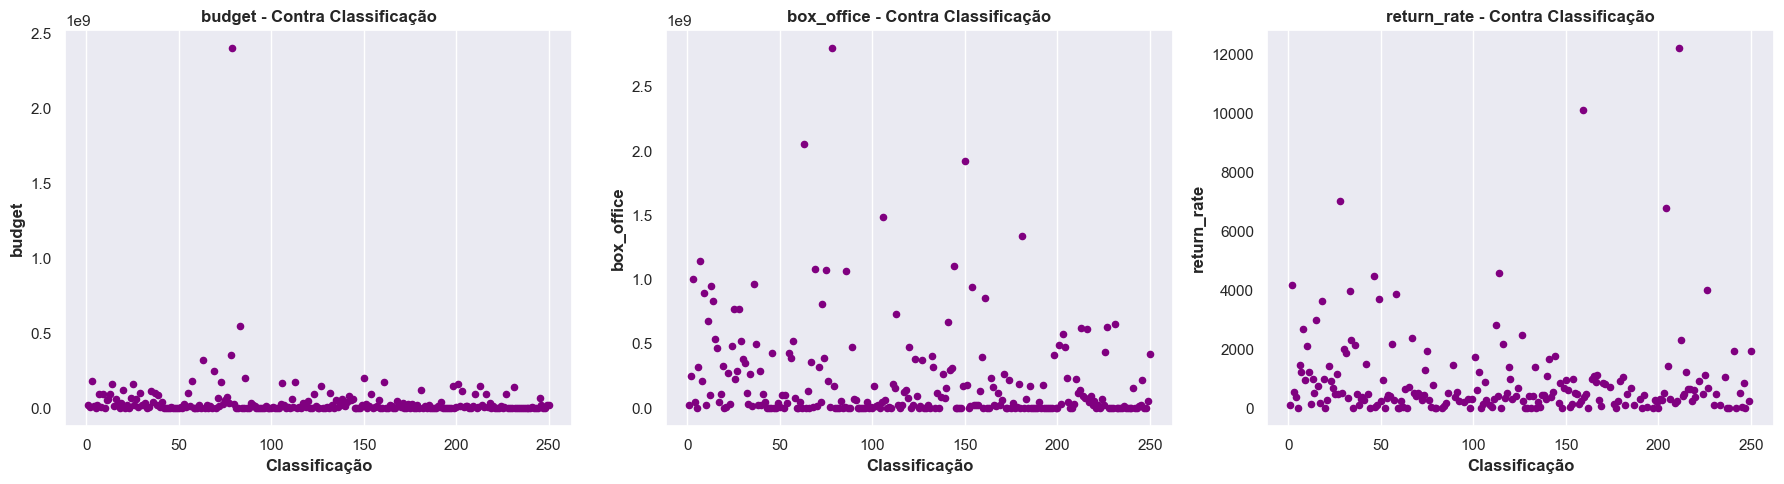

In [41]:
df_returns = dataset[['rank', 'return_rate', 'budget', 'box_office']]

fig, axs = plt.subplots(ncols=3, figsize=(18,5))

for i, cc in enumerate(['budget', 'box_office','return_rate']):    
    ax = df_returns.plot.scatter(x='rank', y=cc, color='purple', ax=axs[i])
    ax.set_title(cc + " - Contra Classificação", weight='bold')
    ax.yaxis.grid()
    ax.set_ylabel(cc, weight='bold')
    ax.set_xlabel('Classificação', weight='bold')
fig.tight_layout()
plt.show()

In [42]:
df_collab = dataset.copy() # Make a deep copy for special modifications

# Here we explode out the lists of directors, writers and casts into individual rows, duplicating all other column info
# This will be useful for analysing collaborations between people later on
for x in ['casts', 'writers', 'directors']:
    # Remove whitespace between names
    # Remove things in parentheses in names e.g. SomeName(co-director)
    df_collab[x] = df_collab[x].str.replace(' ','').str.replace(r"\(.*\)","").str.split(',').to_frame()
    # Explode to individual rows
    df_collab = df_collab.explode(x)
#df_collab.head()

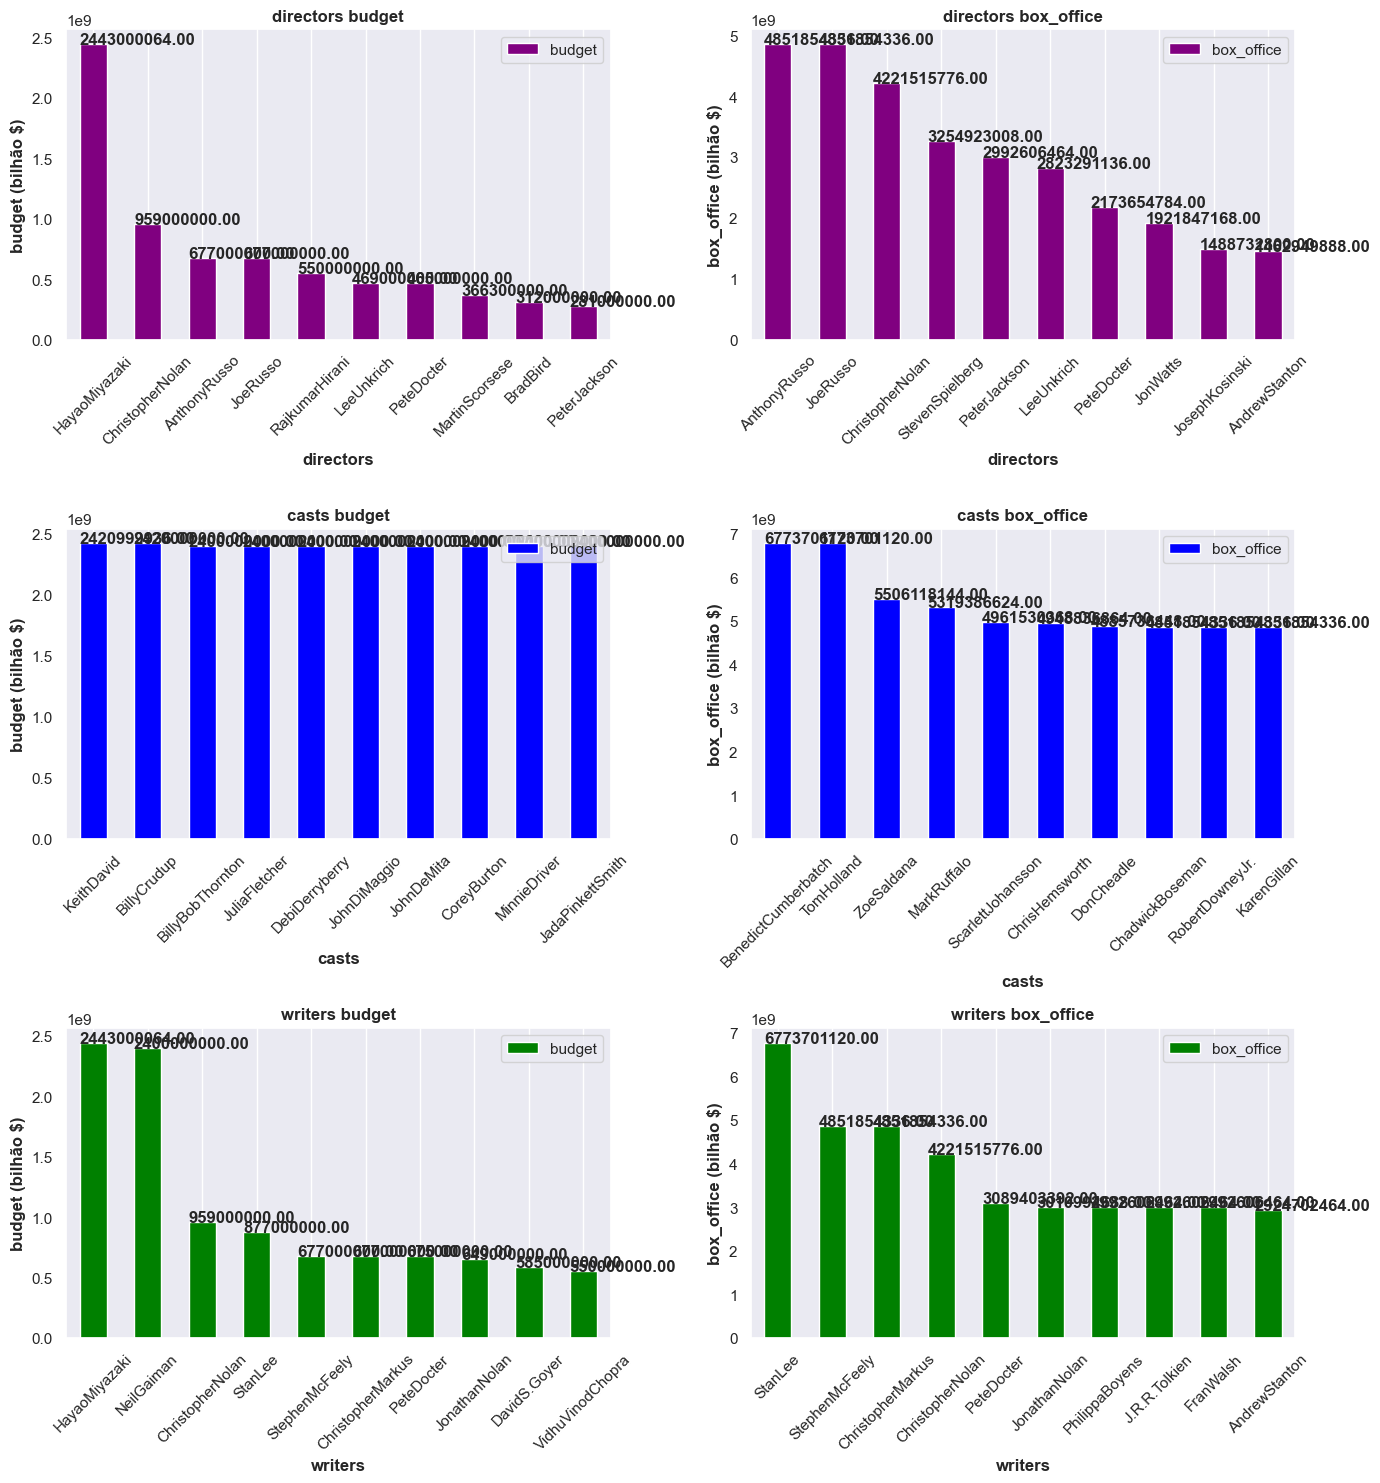

In [43]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

colors = ['purple','blue','green']

for i, cc in enumerate(['directors','casts','writers']):    
    df_agg = df_collab[[cc, 'rank', 'name', 'budget', 'box_office']].drop_duplicates().groupby([cc]).sum().reset_index()
    for j, dd in enumerate(['budget', 'box_office']):
        ax = df_agg.sort_values(dd,ascending=False).head(10).plot.bar(x=cc, y=dd, color=colors[i], ax=axs[i,j], rot=45)
        ax.set_title(cc + " " + dd, weight='bold')
        ax.yaxis.grid()
        ax.set_xlabel(cc, weight='bold')
        ax.set_ylabel(dd + " (bilhão $)", weight='bold')
        bar_annot(ax)
fig.tight_layout()
plt.show()

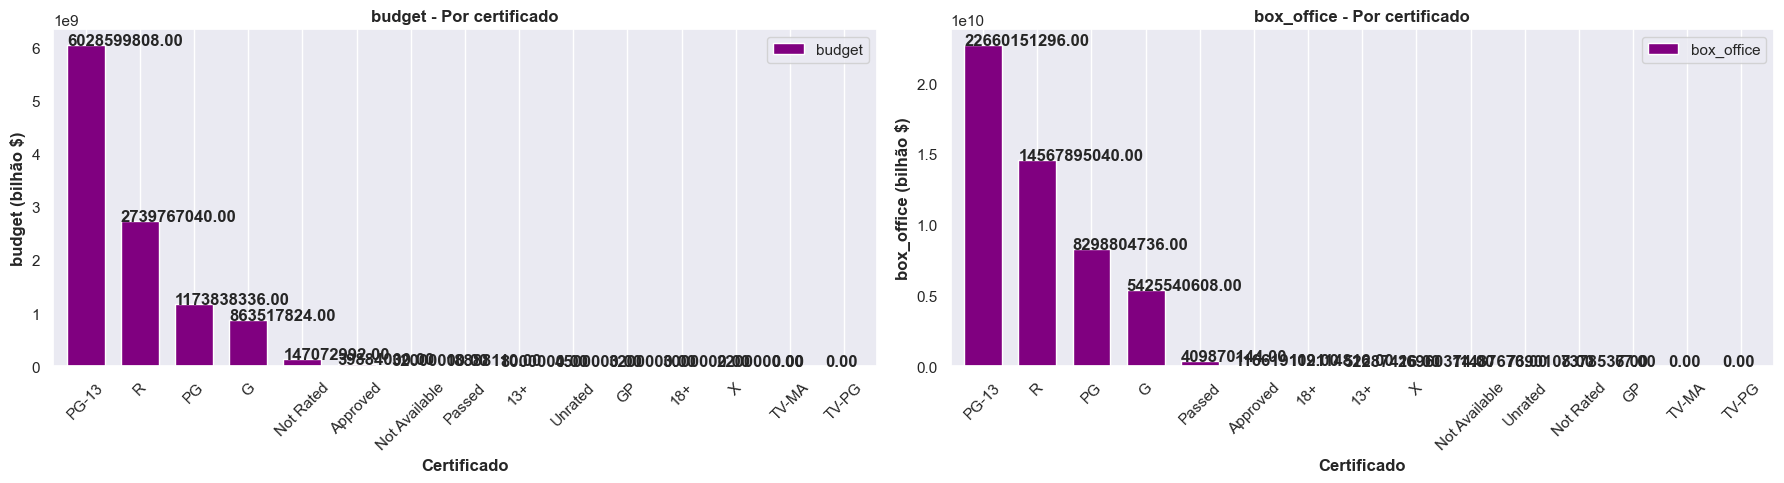

In [44]:
df_cert = dataset[['certificate', 'budget', 'box_office']].groupby(['certificate']).sum().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18,5))

for i, cc in enumerate(['budget', 'box_office']):
    ax = df_cert.sort_values(by=cc, ascending=False).plot.bar(x='certificate', y=cc, color='purple', width=0.7, ax=axs[i], rot=45)
    ax.set_title(cc + " - Por certificado", weight='bold')
    ax.yaxis.grid()
    ax.set_ylabel(cc + ' (bilhão $)', weight='bold')
    ax.set_xlabel('Certificado', weight='bold')
    bar_annot(ax)
fig.tight_layout()
plt.show()

In [45]:
df_genre = dataset.copy() # Make a deep copy for special modifications

# Here we explode out the genres into individual rows, duplicating all other column info
# Remove whitespace between names and split by comma
df_genre['genre'] = df_genre['genre'].str.replace(' ','').str.split(',').to_frame()
df_genre['genre_count'] = df_genre['genre'].apply(lambda x:len(x))

# Some movies have multiple genres attached. In this case, split the financials between each genre, assuming equal weighting
df_genre['budget_split'] = df_genre['budget'] / df_genre['genre_count']
df_genre['box_office_split'] = df_genre['box_office'] / df_genre['genre_count']

# Explode to individual rows
df_genre = df_genre.explode('genre')
#df_genre.head()

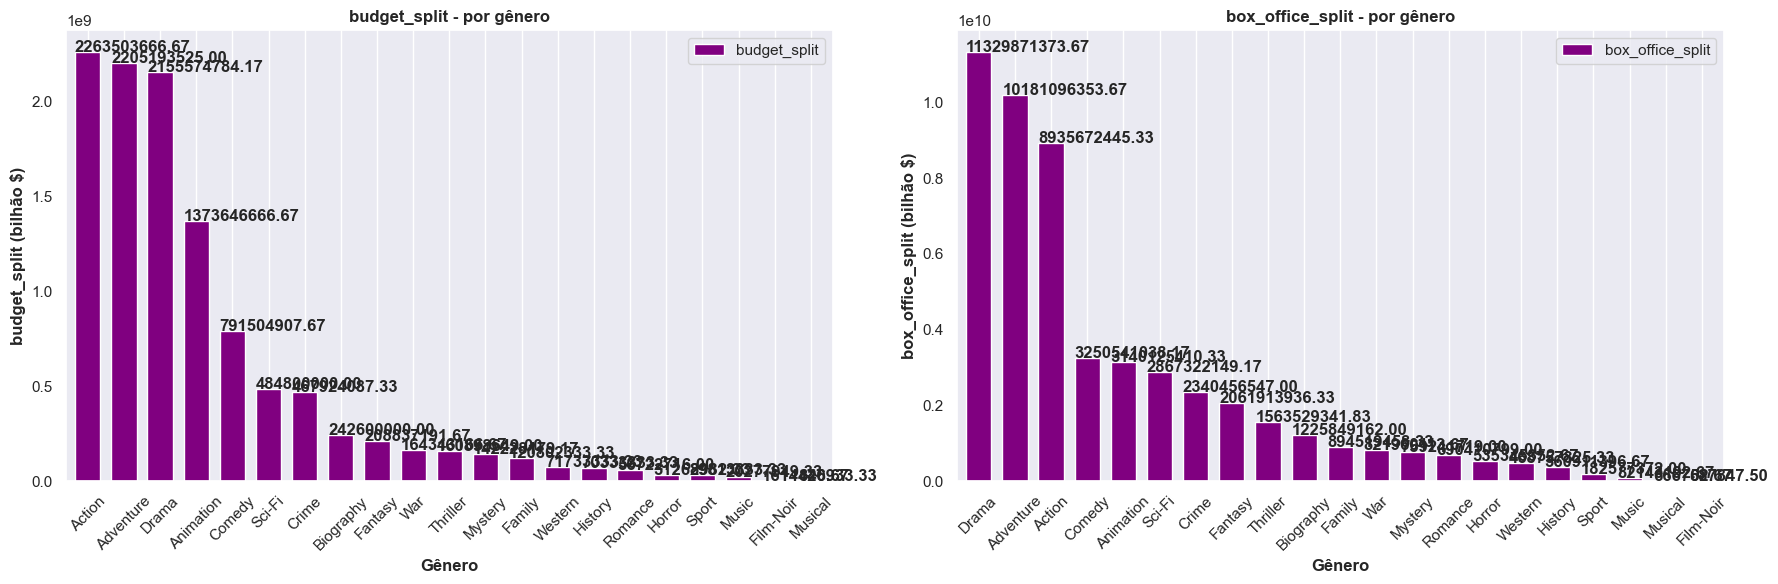

In [46]:
df_genre_agg = df_genre[['genre', 'budget_split', 'box_office_split']].groupby(['genre']).sum().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18,6))

for i, cc in enumerate(['budget_split', 'box_office_split']):
    ax = df_genre_agg.sort_values(by=cc, ascending=False).plot.bar(x='genre', y=cc, color='purple', width=0.7, ax=axs[i], rot=45)
    ax.set_title(cc + " - por gênero", weight='bold')
    ax.yaxis.grid()
    ax.set_ylabel(cc + ' (bilhão $)', weight='bold')
    ax.set_xlabel('Gênero', weight='bold')
    bar_annot(ax)
fig.tight_layout()
plt.show()

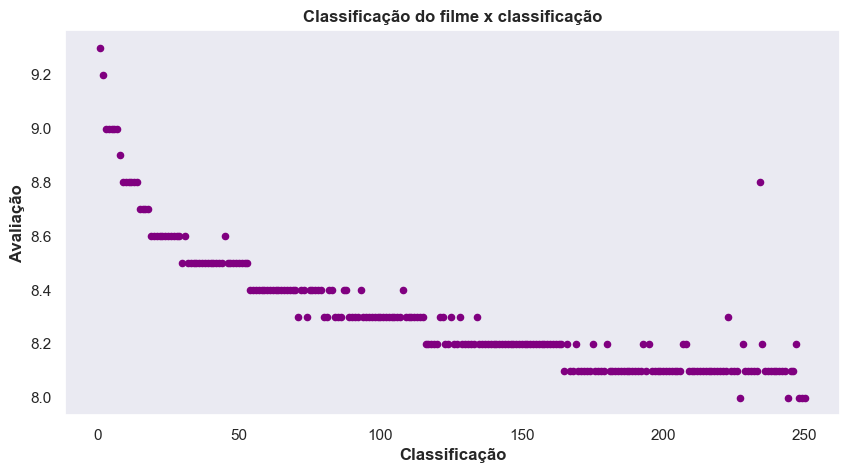

In [47]:
ax = dataset.plot.scatter(x='rank', y='rating', color='purple')
ax.figure.set_size_inches(10,5)
ax.set_title("Classificação do filme x classificação", weight='bold')
ax.yaxis.grid()
ax.xaxis.grid()
plt.ylabel('Avaliação', weight='bold')
plt.xlabel('Classificação', weight='bold')
plt.show()

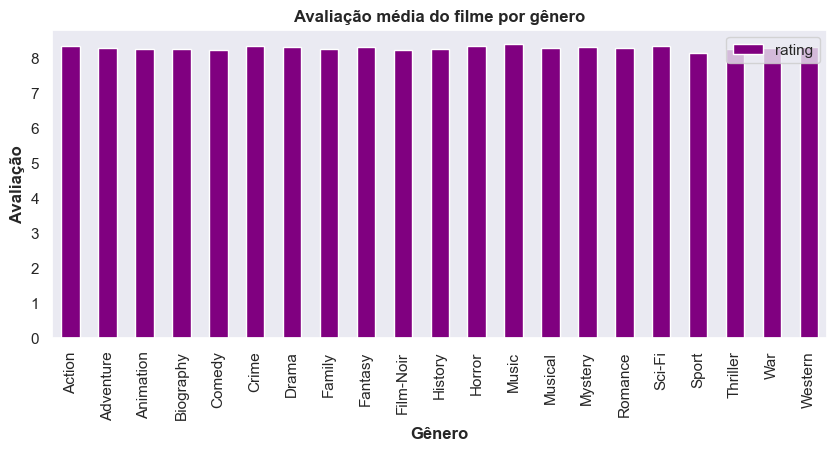

In [48]:
df_genre_agg = df_genre[['genre','rating']].groupby(['genre']).mean().reset_index()

ax = df_genre_agg.plot.bar(x='genre', y='rating', color='purple')
ax.figure.set_size_inches(10,4)
ax.set_title("Avaliação média do filme por gênero", weight='bold')
ax.yaxis.grid()
ax.xaxis.grid()
plt.ylabel('Avaliação', weight='bold')
plt.xlabel('Gênero', weight='bold')
plt.show()

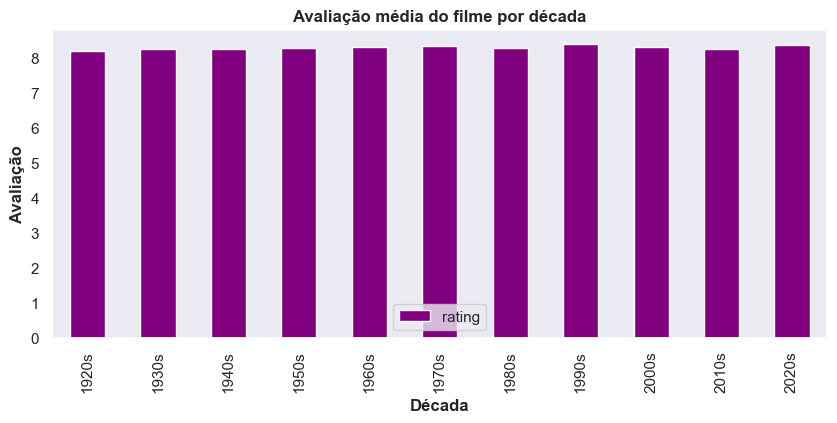

In [49]:
df_rate_agg = dataset[['rating', 'decade']].groupby(['decade']).mean().reset_index()

ax = df_rate_agg.plot.bar(x='decade', y='rating', color='purple')
ax.figure.set_size_inches(10,4)
ax.set_title("Avaliação média do filme por década", weight='bold')
ax.yaxis.grid()
ax.xaxis.grid()
plt.ylabel('Avaliação', weight='bold')
plt.xlabel('Década', weight='bold')
plt.show()

# Exportar o arquivo .csv

In [50]:
dataset['budget'] = dataset['budget'].astype('Int64')
dataset['box_office'] = dataset['box_office'].astype('Int64')

In [51]:
print("Data Size:",dataset.shape)
print("-"* 30)
print("About Dataset:")
dataset.info()
print("-"* 30)
print("Data Columns:",list(dataset.columns))
print("-"* 30)
print("Number of Examples 'N'=",dataset.shape[0])
print("Number of Dimensions 'D'=",dataset.shape[1]-1)
print("-"* 30)
print("Data Check For Any Duplicates:",dataset.duplicated().any())

Data Size: (250, 20)
------------------------------
About Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               250 non-null    int64  
 1   name               250 non-null    object 
 2   year               250 non-null    int64  
 3   rating             250 non-null    float64
 4   genre              250 non-null    object 
 5   certificate        250 non-null    object 
 6   run_time           250 non-null    object 
 7   tagline            250 non-null    object 
 8   budget             250 non-null    Int64  
 9   box_office         250 non-null    Int64  
 10  casts              250 non-null    object 
 11  directors          250 non-null    object 
 12  writers            250 non-null    object 
 13  return_rate        220 non-null    float32
 14  runtime_minutes    249 non-null    float64
 15  genre_s

In [52]:
dataset.to_csv('analise_imdb_planilha_1.csv', index=False)